# Прогнозирование оттока клиента Банка

### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

### План проекта

    1. Предобработка данных
    2. Исследовательский анализ данных
    3. Борьба с дисбалансом классов
    4. Тестирование модели
    5. Выводы

### Описание данных
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

### 1. Предобработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd

from sklearn.preprocessing import StandardScaler

!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

In [2]:
#загружаем датасет:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
# выведем на экран первые 10 строк
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
#выведем общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


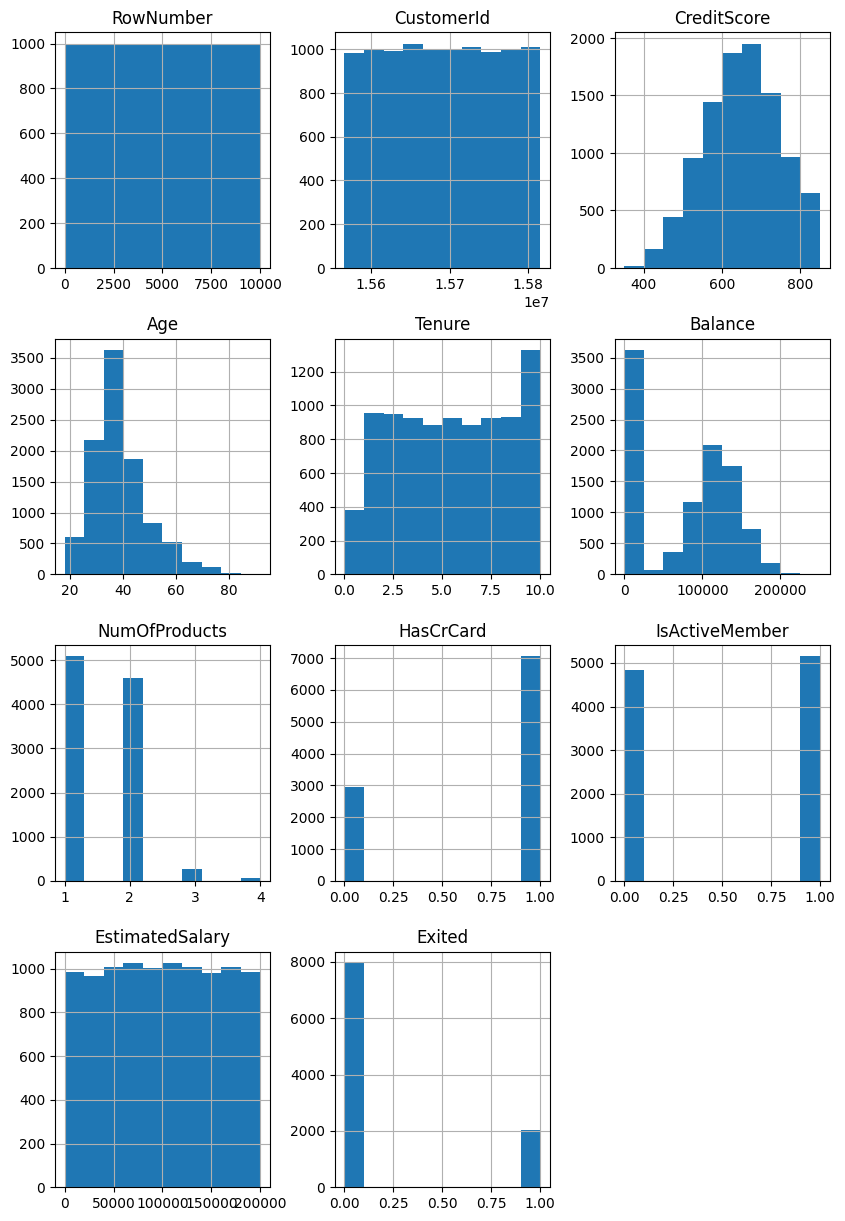

In [5]:
#построим гистограммы
data.hist(figsize=(10,15));

Посмотрим значения категориальных переменных:

In [6]:
# уникальные значения столбца с указанием страны проживания
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
#уникальные значения пола
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Посмотрим внимательнее на пропуски в столбце Tenure:

In [8]:
#выведем несколько строк с пропусками для выявления зависимости
data[data['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Установить явной зависимости между даными и пропусками не получилось, поэтому лучше исключим данные записи из набора данных.

In [9]:
#удаляем из данных столбцы с порядковыми номерами, с уникальными идентификаторами клиентов и фамилиями (данная информация не влияет на предсказание оттока клиентов)
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#а также удаляем строки с пропущенными значениями:
data = data.dropna(subset=['Tenure'])

In [10]:
#изменяем тип данных столбца Tenure
data['Tenure'] = data['Tenure'].astype('int')

In [11]:
data.info() #проверяем сохраненные изменения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   int32  
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 816.8+ KB


In [12]:
#прямое кодирование категориальных признаков
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'NumOfProducts'], drop_first=True)

In [13]:
#масштабирование количественных признаков:
features_num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data[features_num])
data[features_num] = scaler.transform(data[features_num])

In [14]:
#контроль полученных результатов
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,-0.329200,0.289040,-1.035627,-1.227780,1,1,0.020264,1,0,0,0,0,0,0
1,-0.443301,0.194298,-1.381103,0.116887,0,1,0.214527,0,0,1,0,0,0,0
2,-1.542828,0.289040,1.037224,1.333920,1,0,0.238632,1,0,0,0,0,1,0
3,0.500631,0.004815,-1.381103,-1.227780,0,0,-0.110281,0,0,0,0,1,0,0
4,2.066937,0.383782,-1.035627,0.785996,1,1,-0.366132,0,0,1,0,0,0,0


In [15]:
#разбиваем на обучающую, валидационную и тестовую выборки:
features_train, target_train, features_valid, target_valid, features_test, target_test = \
                    train_valid_test_split(data, target='Exited', train_size=0.6, valid_size=0.2, test_size=0.2, random_state=12345)

#для проверки выведем на экран размеры получившихся выборок
print('Обучающая выборка:', features_train.shape, target_train.shape)
print('Валидационная выборка:', features_valid.shape, target_valid.shape)
print('Тестовая выборка:', features_test.shape, target_test.shape)

Обучающая выборка: (5454, 13) (5454,)
Валидационная выборка: (1818, 13) (1818,)
Тестовая выборка: (1819, 13) (1819,)


### Выводы:

    1) В исходных данных предотавлена информация о 10000 клиентах
    2) В результате знакомства с данными были выявлены: 
        - пропущенные значения в столбце с указанием, сколько лет человек является клиентом банка 
        - неверный тип данных для значений в столбце с указанием, сколько лет человек является клиентом банка
        - столбцы с указанием индекса строки в данных, уникального идентификатора клиента и фамилией клиента не несут смысловой нагрузки для определения оттока клиентов
        - аномальные значения в столбцах с числовыми признаками не выявлены
        - столбец с указанием количества продуктов банка, используемых клиентом, является категориальной переменной (принимает значения только 1, 2, 3 или 4)
        - аномальные значения в столбцах с категориальными признаками не выявлены
    3) В результате предобработки данных:
        - неинформативные столбцы исключены
        - строки с пропущенными значениями в столбце с указанием, сколько лет человек является клиентом банка, исключены 
        - тип данных столбца с указанием, сколько лет человек является клиентом банка, изменен на целочисленный
        - произведено прямое кодирование категориальных признаков
        - произведено масштабирование количественных признаков
        - данные разделены на обучающую, валдационную и тестовую выборки

### Исследовательский анализ данных

In [16]:
#оценим баланс классов в обучающей выборке:
target_train.value_counts()

0    4328
1    1126
Name: Exited, dtype: int64

Построим модели по разным алгоритмам, произведем сравнение полученных метрик f1 и AUC-ROC:

In [17]:
#создадим таблицу score_all для хранения полученных значений метрик (изначально заполненную 0)
score_all = pd.DataFrame(0, index=['f1_unbalanced', 'auc_roc_unbalanced', 'f1_balanced_upsampling', \
                                   'auc_roc_balanced_upsampling', 'f1_balanced_downsampling', 'auc_roc_balanced_downsampling',], \
                         columns=['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression'])

In [18]:
#дерево решений:
model = DecisionTreeClassifier(random_state=2022)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
#сохраняем значения полученных метрик в таблицу
score_all.loc['f1_unbalanced', 'DecisionTreeClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_unbalanced', 'DecisionTreeClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [19]:
#случайный лес:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
#сохраняем значения полученных метрик в таблицу
score_all.loc['f1_unbalanced', 'RandomForestClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_unbalanced', 'RandomForestClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [20]:
#логистическая регрессия:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
#сохраняем значения полученных метрик в таблицу
score_all.loc['f1_unbalanced', 'LogisticRegression'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_unbalanced', 'LogisticRegression'] = roc_auc_score(target_valid, predicted_valid)

In [21]:
#сравним значения метрик для моделей, построенных по разным алгоритмам:
score_all

,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
f1_unbalanced,0.491979,0.573798,0.506849
auc_roc_unbalanced,0.679146,0.711053,0.675815
f1_balanced_upsampling,0.000000,0.000000,0.000000
auc_roc_balanced_upsampling,0.000000,0.000000,0.000000
f1_balanced_downsampling,0.000000,0.000000,0.000000
auc_roc_balanced_downsampling,0.000000,0.000000,0.000000


### Выводы:
    
       1) В обучающей выборке отсутствует баланс классов
       2) Лучшее значение метрики f1 достигнуто RandomForestClassifier
       3) Лучшее значение метрики AUC-ROC также достигнуто RandomForestClassifier
       4) Значения метрик AUC-ROC больше значений f1
      

### 3. Борьба с дисбалансом

1) Для борьбы с дисбалансом используем увеличение выборки:

In [22]:
# функция upsampling
def upsampling(features, target):
    #разделяем выборку на 0 и 1
    features_zeros = features[target==0]
    target_zeros = target[target==0]
    features_ones = features[target==1]
    target_ones = target[target==1]
    #копируем объекты с 1 и добавляем их в выборку
    features_upsampled = pd.concat([features_zeros]+[features_ones]*round(target[target==0].shape[0]/target[target==1].shape[0]))
    target_upsampled = pd.concat([target_zeros]+[target_ones]*round(target[target==0].shape[0]/target[target==1].shape[0]))
    #перемешиваем данные
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [23]:
#сбалансируем данные функцией upsampling:
features_train_upsampled, target_train_upsampled = upsampling(features_train, target_train)

Построим модели по разным алгоритмам, произведем сравнение полученных метрик f1 и AUC-ROC:

In [24]:
#дерево решений:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_upsampling', 'DecisionTreeClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_upsampling', 'DecisionTreeClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [25]:
#случайный лес:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_upsampling', 'RandomForestClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_upsampling', 'RandomForestClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [26]:
#логистическая регрессия:
model = LogisticRegression(random_state=12345)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_upsampling', 'LogisticRegression'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_upsampling', 'LogisticRegression'] = roc_auc_score(target_valid, predicted_valid)

2) Для борьбы с дисбалансом используем уменьшение выборки:

In [27]:
# функция downsampling
def downsampling(features, target):
    #разделяем выборку на 0 и 1
    features_zeros = features[target==0]
    target_zeros = target[target==0]
    features_ones = features[target==1]
    target_ones = target[target==1]
    #случайным образом отбрасываем часть данных с 0
    frac = 1/(target[target==0].shape[0]/target[target==1].shape[0])
    features_downsampled = pd.concat([features_zeros.sample(frac=frac, random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=frac, random_state=12345)]+[target_ones])
    #перемешиваем данные
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [28]:
#сбалансируем данные функцией downsampling:
features_train_downsampled, target_train_downsampled = downsampling(features_train, target_train)

In [29]:
#дерево решений:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_downsampling', 'DecisionTreeClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_downsampling', 'DecisionTreeClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [30]:
#случайный лес:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_downsampling', 'RandomForestClassifier'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_downsampling', 'RandomForestClassifier'] = roc_auc_score(target_valid, predicted_valid)

In [31]:
#логистическая регрессия:
model = LogisticRegression(random_state=12345)
model.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model.predict(features_valid)
score_all.loc['f1_balanced_downsampling', 'LogisticRegression'] = f1_score(target_valid, predicted_valid)
score_all.loc['auc_roc_balanced_downsampling', 'LogisticRegression'] = roc_auc_score(target_valid, predicted_valid)

In [32]:
#сравним значения метрик для выборок, сбалансированных разными методами, и для моделей, построенных по разным алгоритмам:
score_all

,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
f1_unbalanced,0.491979,0.573798,0.506849
auc_roc_unbalanced,0.679146,0.711053,0.675815
f1_balanced_upsampling,0.457995,0.610072,0.570874
auc_roc_balanced_upsampling,0.657518,0.744387,0.765354
f1_balanced_downsampling,0.491196,0.592145,0.568116
auc_roc_balanced_downsampling,0.699828,0.778192,0.763619


### Выводы:

    1) После балансировки классов  значения метрик увеличились, за исключением классификатора дерева решений
    2) Лучшее значение метрики f1 у классификатора случайного леса, построенного на сбалансированной выборке с увеличением выборки
    3) Значения метрики AUC-ROC выше значений f1

Далее для улучшени метрики f1 подберем по сетке гиперпараметры случайного леса, обученного на выборке с увеличением выборки:

In [33]:
# настройка гиперпараметров
params = {'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120],
         'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]} #варианты гиперпараметров, которые будем использовать
model = GridSearchCV(RandomForestClassifier(random_state=12345), params, scoring='f1') #подбор гиперпараметров по сетке
model.fit(features_train_upsampled, target_train_upsampled)

GridSearchCV(estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120]},
             scoring='f1')

In [34]:
# расчет метрик f1 и AUC-ROC итоговой модели:
predicted_valid = model.predict(features_valid)
print('Метрика f1=', f1_score(target_valid, predicted_valid))
print('Метрика AUC-ROC=', roc_auc_score(target_valid, predicted_valid))

Метрика f1= 0.6142649199417758
Метрика AUC-ROC= 0.7454897037681981


### 4. Тестирование модели

In [35]:
predicted_test = model.predict(features_test)
print('Метрика f1=', f1_score(target_test, predicted_test))
print('Метрика AUC-ROC=', roc_auc_score(target_test, predicted_test))

Метрика f1= 0.612184249628529
Метрика AUC-ROC= 0.7539377566625522


### 5. Выводы:

    1) В результат подготовки данных:
        - неинформативные столбцы исключены
        - строки с пропущенными значениями в столбце с указанием, сколько лет человек является клиентом банка, исключены 
        - тип данных столбца с указанием, сколько лет человек является клиентом банка, изменен на целочисленный
        - произведено прямое кодирование категориальных признаков
        - произведено масштабирование количественных признаков
        - данные разделены на обучающую, валдационную и тестовую выборки
    2) В результате исследования:
        - выявлен дисбаланс классов обучающей выборки
        - построены модели с использованием алгоритмов решающего дерева, случайного леса и логистической регрессии
        - лучшее значение метрики f1 достигнуто случайным лесом
        - лучшее значение метрики AUC-ROC также достигнуто случайным лесом
        - значения AUC-ROC больше значений f1
     3) В результате учета дисбаланса:
         - построены изученные раннее модели на обучающей выборке, сбалансированной увеличением выборки
         - построены изученные раннее модели на обучающей выборке, сбалансированной уменьшением выборки
         - лучшее значение метрики f1 достигнуто случайным лесом на выборке, сбалансированной увеличением выборки
         - после балансировки классов  значения метрик увеличились, за исключением классификатора дерева решений
         - значения AUC-ROC больше значений f1
         - подобраны гиперпараметры случайного леса по сетке для получения наибольшего значения метрики f1
      4) В результате тестирования на тестовой выборке получено значение метрики f1=0,61